<a href="https://colab.research.google.com/github/paulgureghian/Google_Colab_Notebooks/blob/master/Style_Transfer_PyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Created by Paul A. Gureghian on 12/13/18.**

**Style Transfer with Deep Neural Networks.**

**In this notebook, I’ll create a style transfer method in PyTorch.**

**I will use the 19-layer VGG Network to extract and separate content and style features.**

**I will use that information to form a target image.**

*   **target objects and their arrangement are similar to that of the  content image.**
*   **target style, colors, and textures are similar to that of the style image.**





In [47]:
### Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
### Install Pillow
!pip install pillow==4.1.1  

In [0]:
### Install PyTorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
### Import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

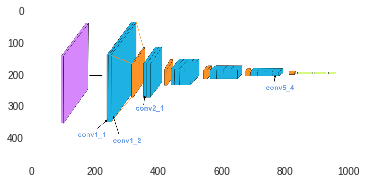

In [51]:
### VGG-19 Network image
vgg19 = mpimg.imread("/content/drive/My Drive/Images/vgg19_convlayers.png") 
plt.imshow(vgg19)
plt.grid(False)

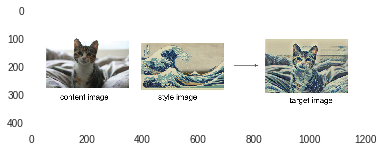

In [52]:
### Stylized cat target image 
stylized_cat = mpimg.imread("/content/drive/My Drive/Images/style_tx_cat.png") 
plt.imshow(stylized_cat)
plt.grid(False)

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

I only need the `features` portion, which I am going to load in and "freeze" the weights of, below.

In [0]:
### Get the "features" portion of VGG19 
vgg = models.vgg19(pretrained=True).features

### Freeze all VGG parameters since I am only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [54]:
### Move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

**Load in Content and Style Images.**

In [0]:
### Image loader function
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

**Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.**

In [0]:
### Load in content image
content = load_image("/content/drive/My Drive/Images/octopus.jpg").to(device)

### Load and resize style image to match content
style = load_image("/content/drive/My Drive/Images/hockney.jpg", shape=content.shape[-2:]).to(device)

In [0]:
### Helper function for un-normalizing an image 
### And converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

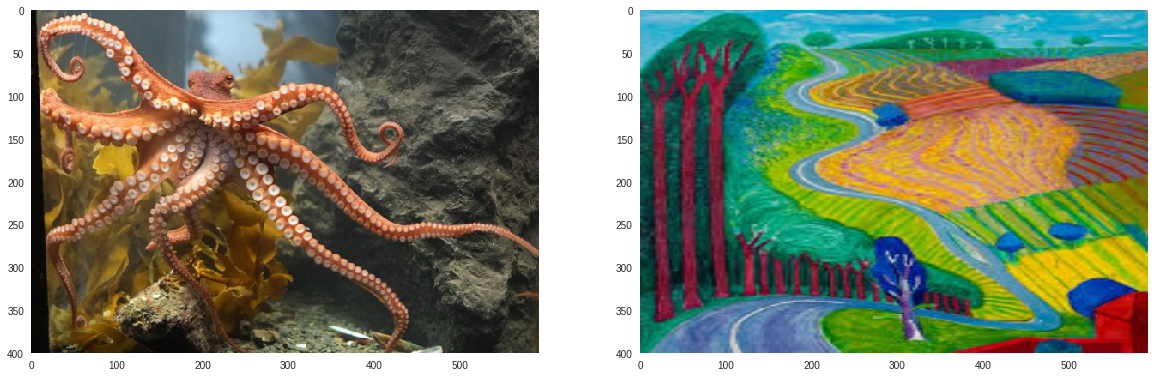

In [58]:
### Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

### Content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax1.grid(False)
ax2.grid(False)

**VGG19 Layers.**

**To get the content and style representations of an image, I have to pass an image forward throug the VGG19 network until I get to the desired layer(s) and then get the output from that layer.**

In [59]:
### Print out VGG19 structure names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

**Content and Style Features.**

**Below, I will complete the mapping of layer names to the names found in the model for the _content representation_ and the _style representation_.**

In [0]:
### Extract features from the layers
def get_features(image, model, layers=None):
            
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

**The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:**


* **Get the depth, height, and width of a tensor.**
* **Reshape that tensor so that the spatial dimensions are flattened.**
* **Calculate the gram matrix by multiplying the reshaped tensor by it's transpose** 

In [0]:
### Define a 'Gram Matrix'
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

**Putting it all Together.**

**Now that I've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together. I'll extract features from the images and calculate the gram matrices for each layer in the style representation.**

In [0]:
### Get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

### Calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

### Create a "target" image and prep it for change
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Individual Layer Style Weights

I will weight the style representation at each relevant layer. I will use a range between 0-1 to weight these layers. By weighting earlier layers (`conv1_1` and `conv2_1`) more, I can expect to get _larger_ style artifacts in the resulting, target image. Should I choose to weight later layers, I'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation.

#### Content and Style Weight

I define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ the final image is. I will leave the content_weight = 1 and set the style_weight to achieve the ratio I want.

In [0]:
### Weights for each style layer 
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target & Calculating Losses

I'll decide on a number of steps for which to update the image.

Inside the iteration loop, I'll calculate the content and style losses and update the target image, accordingly.

#### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

The style loss is calculated in a similar way, only I have to iterate through a number of layers, specified by name in the dictionary `style_weights`. 
> I'll calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`. 
> Later, you'll see that this value is normalized by the size of the layer.

#### Total Loss

Finally, I'll create the total loss by adding up the style and content losses and weighting them with the specified alpha and beta.

Intermittently, I'll print out this loss. I should see that this loss decreases over some number of iterations.

Total loss:  49116680.0


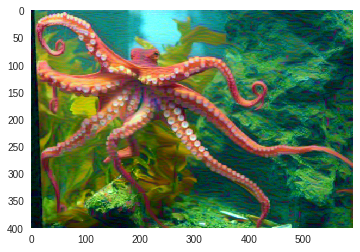

Total loss:  9946818.0


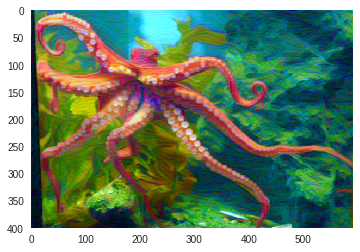

Total loss:  5174134.5


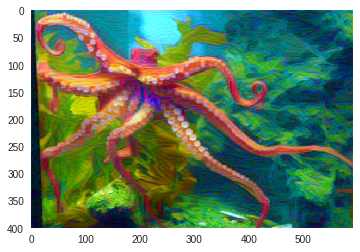

Total loss:  3145614.25


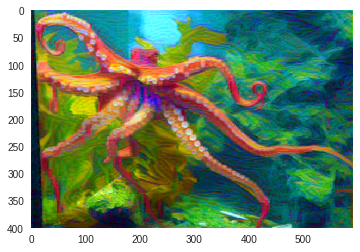

Total loss:  2024624.5


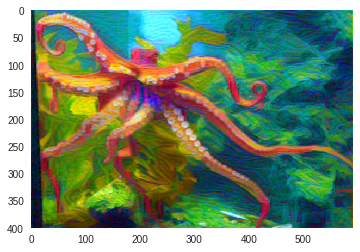

In [64]:
### Update the target
### Interval for displaying the target image
show_every = 400

### Loop hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  

### 'For' loop through the target features
for ii in range(1, steps+1):
    
    ### Get the features from the target image
    target_features = get_features(target, vgg)
    
    ### The content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    ### The style loss
    ### Initialize the style loss to 0
    style_loss = 0
    
    ### Then add to it for each layer's gram matrix loss
    for layer in style_weights:
        
        ### Get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        ### Get the "style" style representation
        style_gram = style_grams[layer]
        
        ### The style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        ### Add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    ### Calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    ### Update the target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    ### Display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.grid(False)
        plt.show()

## Display the Target Image

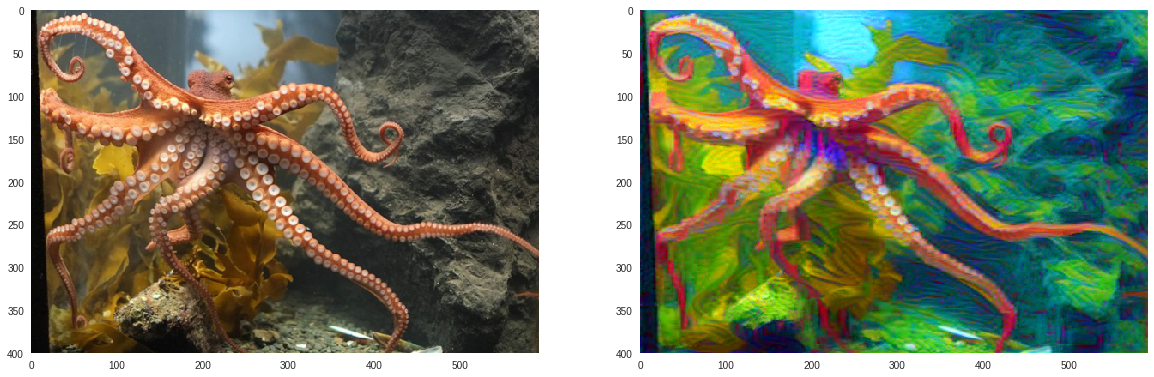

In [65]:
### Display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
ax1.grid(False)
ax2.grid(False)